In [1]:
# !pip install Pillow

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from os import listdir, makedirs, remove
from os.path import dirname, join, exists, isdir
from sklearn.datasets.base import Bunch

D:\Proiecte\AI\armd\.env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
data_folder_path = r'D:\Proiecte\AI\armd\data\raw\02_oct\02_Kermany\experiment'

In [5]:
class_names = listdir(data_folder_path)
class_names

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [6]:
def imread(img_path):
    im = cv2.imread(img_path, 0)
    return im

In [7]:
def fill_outer_whites(img):
    ## (1) Convert to gray, and threshold
    th, threshed = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY_INV)

    ## (2) Morph-op to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    ## (3) Fill in the outer white spaces of the image with black
    mask = cv2.bitwise_not(morphed)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.dilate(mask,kernel,iterations = 2)

    new_img = cv2.subtract(img,mask)
    return new_img

In [8]:
def _load_scans(file_paths, resize=None, resize_shape=None):
   
    if isinstance(resize, tuple):
        h, w = resize
    elif resize is None:
        h, w = 500, 500
    else:
        raise NotImplementedError()
          
    # allocate some contiguous memory to host the decoded image slices
    n_scans = len(file_paths) 
    scans = np.zeros((n_scans, h, w), dtype=np.float32)
    
    # iterate over the collected file path to load the jpeg files as numpy
    # arrays
    for i, file_path in enumerate(file_paths):
#         if i % 1000 == 0:
#             logger.debug("Loading face #%05d / %05d", i + 1, n_scans)
            
        # Checks if jpeg reading worked. Refer to issue #3594 for more
        # details.
        img = imread(file_path)
        if img.ndim == 0:
            raise RuntimeError()
            
        img = fill_outer_whites(img)
        
        scan = np.asarray(img, dtype=np.float32)   
        scan /= 255.0
        
        scan = cv2.resize(img, (h,w))
        
        scans[i, ...] = scan
        
    return scans

In [9]:
affection_types, file_paths = [], []
for affection_type in sorted(listdir(data_folder_path)):
    folder_path = join(data_folder_path, affection_type)
    if not isdir(folder_path):
            continue
    paths = [join(folder_path, f) for f in sorted(listdir(folder_path))]
    n_scans = len(paths)
    if n_scans >= 0:
        affection_types.extend([affection_type] * n_scans)
        file_paths.extend(paths)

# encode to target into ints
target_names = np.unique(affection_types)
target = np.searchsorted(target_names, affection_types)

scans = _load_scans(file_paths)

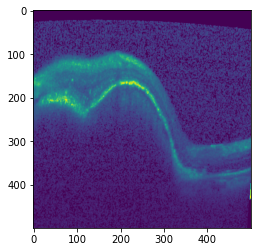

In [10]:
plt.imshow(scans[0])

In [11]:
from sklearn.decomposition import PCA

In [42]:
reshaped = scans.reshape(scans.shape[0], -1)
pca = PCA(0.95).fit(reshaped)

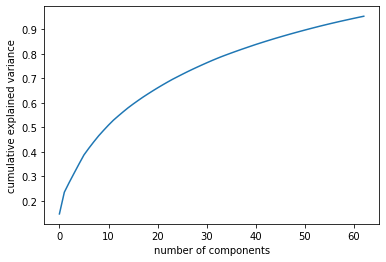

In [43]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [52]:
components = pca.transform(reshaped)
projected = pca.inverse_transform(components)
# clip images to 0, 255 interval 
projected = [np.clip(p, 0, 255) for p in projected]

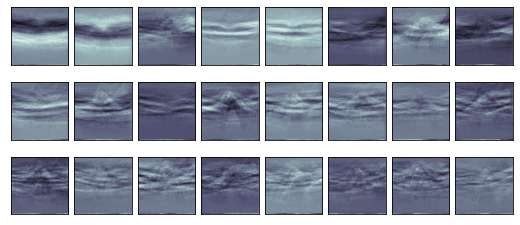

In [53]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(500, 500), cmap='bone')

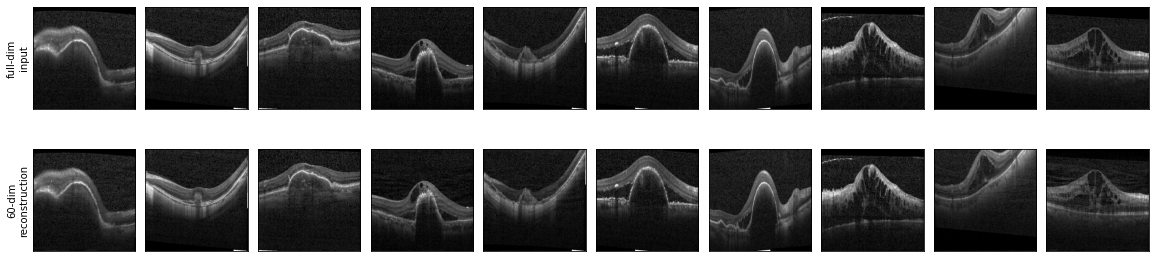

In [58]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(20, 5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(reshaped[i].reshape(500, 500), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(500, 500), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('60-dim\nreconstruction');

In [59]:
from sklearn.metrics import mean_squared_log_error

In [61]:
mean_error = 0
for r, p in zip(reshaped, projected):
    mean_error += mean_squared_log_error(r, p)
mean_error / len(reshaped)

0.2406959907671848